# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [3]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX,
               logr, parallel, 
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [5]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

In [6]:
# Set directories
fastq.dir = "/nfs/lab/projects/COVID_mouse/raw_data/230616_A01535_0344_BH7LF2DSX7_2/"
base.dir = "/nfs/lab/projects/COVID_mouse/"
assets.dir = "/nfs/lab/projects/COVID_mouse/assets/"
cell.ranger.dir = paste(base.dir, "cell.ranger/", sep = "")
seurat.dir = paste(base.dir, "seurat/", sep = "")
step1.dir = paste(seurat.dir, "1_pre.processing/", sep = "")
step2.dir = paste(seurat.dir, "2_SoupX/", sep = "")
step3.dir = paste(seurat.dir, "3_scrublet/", sep = "")
step4.dir = paste(seurat.dir, "4_merge.samples/", sep = "")

In [48]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
compartment.ls = unique(cell.markers$Compartment)
celltype.ls = unique(cell.markers$Celltype)
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = compartment.ls)
cell.markers$CellType = factor(cell.markers$Celltype,
                        levels = celltype.ls)

gather: reorganized (Marker_1, Marker_2, Marker_3, Marker_4, Marker_5, …) into (Key, marker) [was 29x8, now 174x4]


In [49]:
# start log
options("logr.on" = TRUE, "logr.notes" = TRUE)
options("logr.autolog" = TRUE)
options("logr.compact" = TRUE)
options("logr.traceback" = TRUE)
log.file = paste(base.dir, Sys.Date(),".5_MergesamplesV2.log", sep="")

In [50]:
log_open(log.file)

[1] "/nfs/lab/projects/COVID_mouse/log/2023-08-24.5_MergesamplesV2.log"

# Load sample list

In [51]:
setwd(cell.ranger.dir)
sample.ls = dir()
sample.ls
sample.ID.ls = sample.ls

[1] "1_GFP1"  "10_G1C1" "11_G1C2" "12_G1C3" "2_GFP2"  "3_GFP3"  "4_RBD1" 
 [8] "5_RBD2"  "6_RBD3"  "7_G1B1"  "8_G1B2"  "9_G1B3"

# Merge RNA assay

In [10]:
# Set up a parallel backend
cores <- 5
cl <- makeCluster(cores)
setDefaultCluster(cl)

# Define a function to load and modify adata for a given sample ID
load_adata <- function(i) {
  gc(reset = TRUE)
  log_print(paste("Processing: ", i))
  # Load sample
  adata <- readRDS(paste(step3.dir, i, "_filt.rm_mult.rds", sep = "")) 
  DefaultAssay(adata) <- "RNA"
  return(adata)
}

In [11]:
# Load and modify adata in parallel using mclapply
adata.ls <- mclapply(sample.ID.ls, load_adata, mc.cores = cores)

# Clean up the parallel backend
setDefaultCluster(NULL)
stopCluster(cl)

In [12]:
#merge RNA objects (make sure you add sample prefix to these or it won't combine with ATAC)
adata <- merge(adata.ls[[1]],
               y = adata.ls[2:length(adata.ls)],
               add.cell.ids = sample.ID.ls,
               project = 'snRNAseq')

In [13]:
# Add sample ID
library = str_split_fixed(rownames(adata[[]]), '_', n=4)[,1:3]
library = paste(library[,1], "_", library[,2], sep = "")
adata$library <- library
adata

An object of class Seurat 
84243 features across 177038 samples within 3 assays 
Active assay: RNA (32285 features, 0 variable features)
 2 other assays present: RNA_raw, SCT

In [14]:
rm(adata.ls)

# Harmonization

In [15]:
# RNA analysis
DefaultAssay(adata) <- 'RNA'
adata <- SCTransform(adata, verbose = FALSE) 
gc(reset = TRUE)

DefaultAssay(adata) <- "SCT"
adata = RunPCA(adata, verbose = FALSE)
adata = RunHarmony(adata, group.by.vars='library', assay.use='SCT', reduction.save='harmony')

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11496780,614.0,18627121,994.8,11496780,614.0
Vcells,4004542378,30552.3,21134287351,161241.9,4004542378,30552.3


Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony converged after 9 iterations



In [16]:
adata = RunUMAP(adata, reduction = "harmony", dims = 1:20)
adata = FindNeighbors(adata, reduction = "harmony", dims = 1:20)
adata = FindClusters(adata, algorithm = 4, resolution = 0.5, method = "igraph")

11:14:06 UMAP embedding parameters a = 0.9922 b = 1.112

11:14:06 Read 177038 rows and found 20 numeric columns

11:14:06 Using Annoy for neighbor search, n_neighbors = 30

11:14:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:14:30 Writing NN index file to temp file /nfs/lab/Luca/TMP/RtmpXkEoqt/file3b98c61ec76c4c

11:14:33 Searching Annoy index using 1 thread, search_k = 3000

11:15:55 Annoy recall = 100%

11:15:57 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:16:06 Initializing from normalized Laplacian + noise (using irlba)

11:17:13 Commencing optimization for 200 epochs, with 7195842 positive edges

11:18:57 Optimization finished

Computing nearest neighbor graph

Computing SNN



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



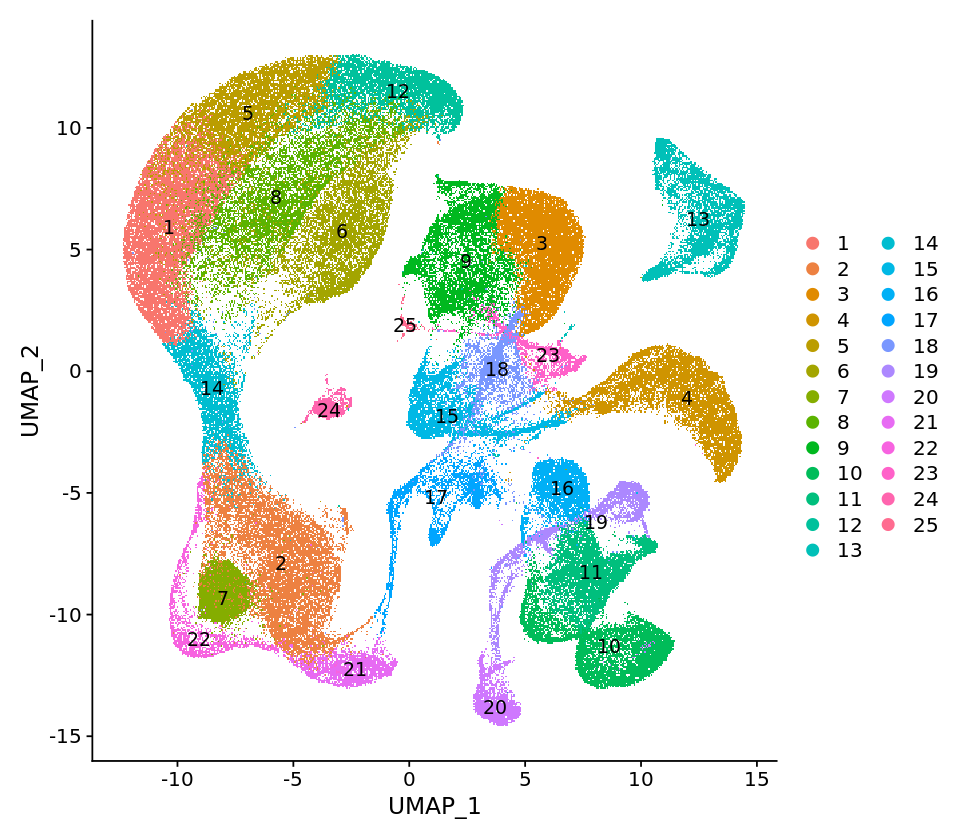

In [17]:
options(repr.plot.height = 7, repr.plot.width = 8)
DimPlot(adata, reduction = "umap", label = TRUE, pt.size = .1)

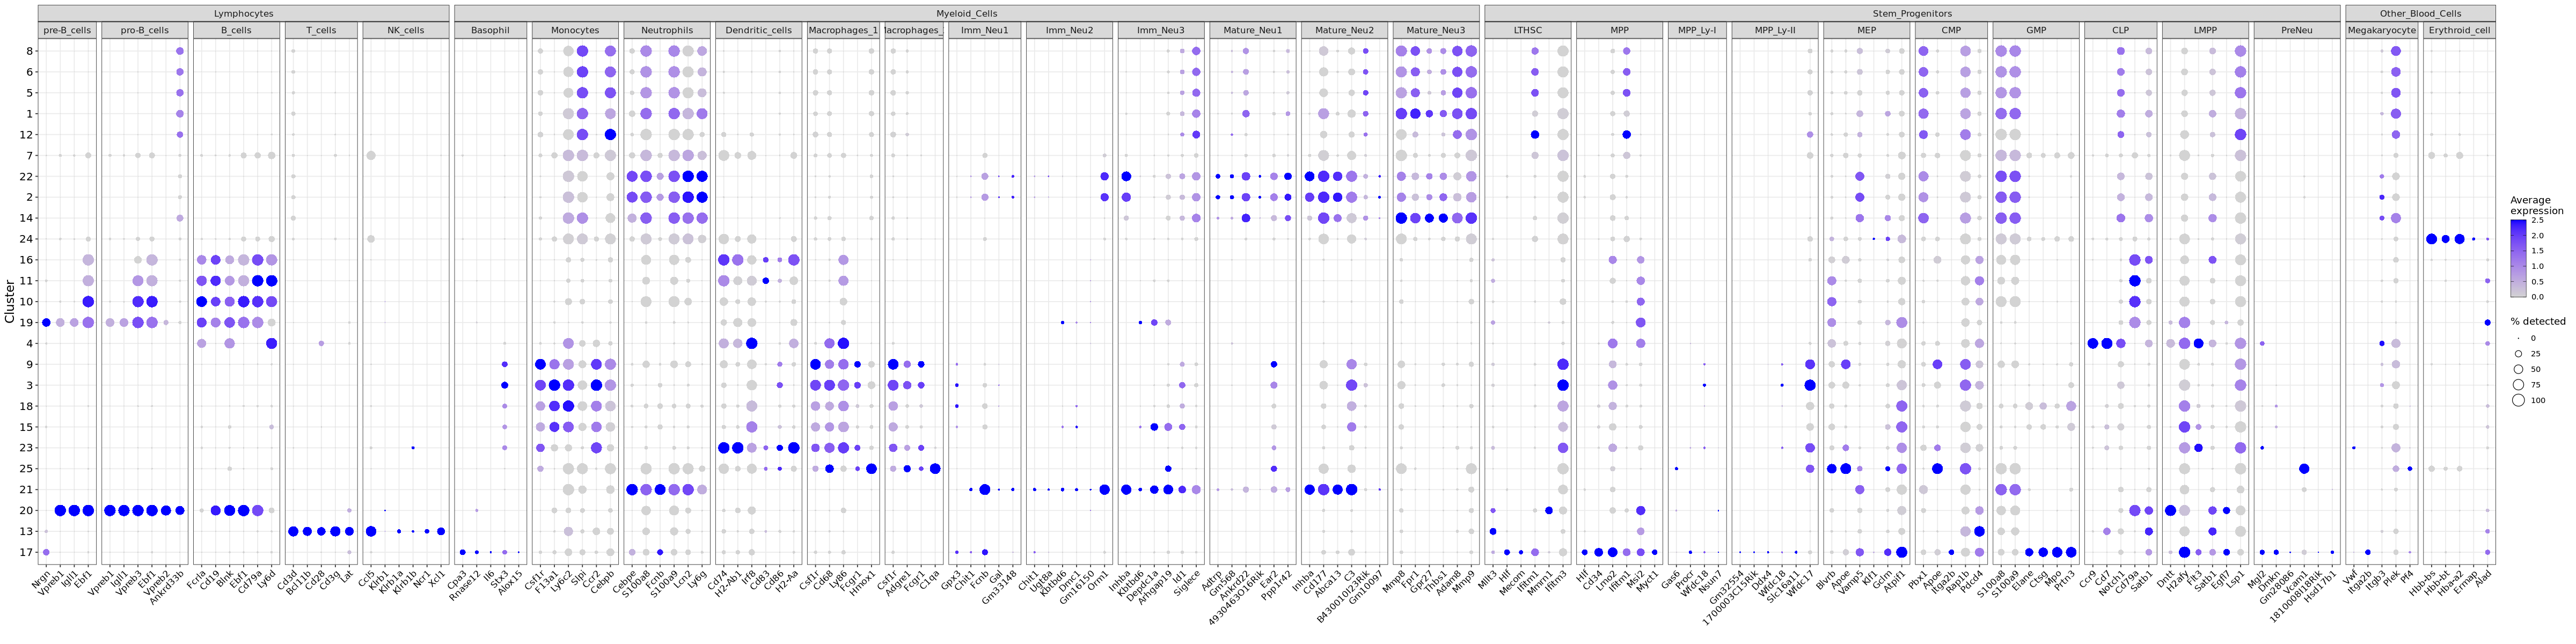

In [85]:
# Filter markers list for only genes present in the dataset
valid_features <- intersect(cell.markers$marker, rownames(adata[["SCT"]]))
g = DotPlot(adata, assay='SCT', features=valid_features, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=40, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

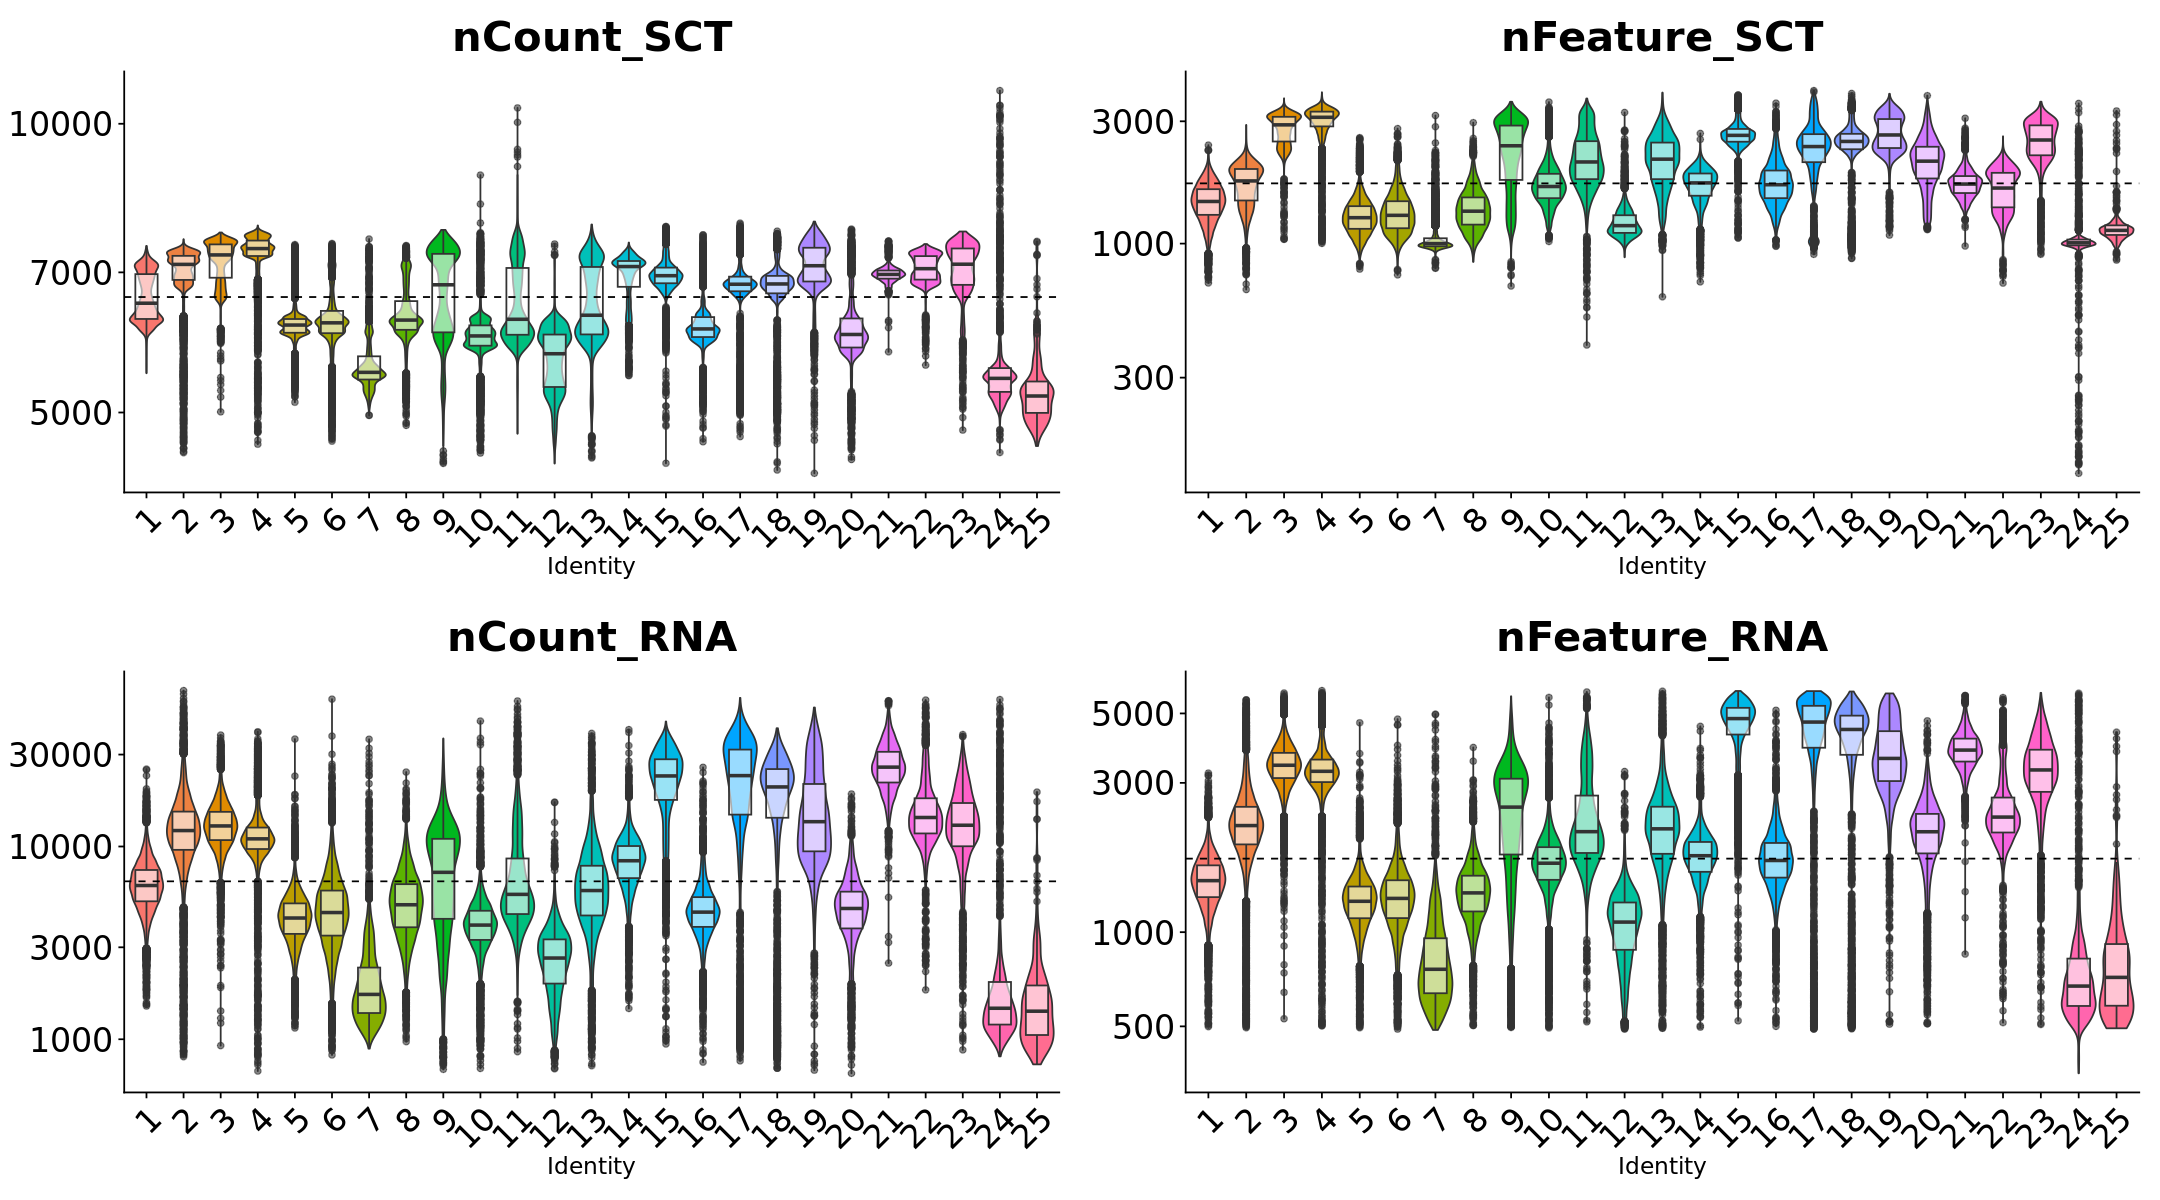

In [18]:
    options(repr.plot.width=18, repr.plot.height=10)   
    p1 <- VlnPlot(adata, features='nCount_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    p2 <- VlnPlot(adata, features='nFeature_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    p3 <- VlnPlot(adata, features='nCount_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    p4 <- VlnPlot(adata, features='nFeature_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    figure <- ggarrange(p1, p2, p3, p4, ncol = 2, nrow = 2,
                        common.legend = TRUE,legend="none")
    figure

In [19]:
p1 <- DimPlot(adata, reduction='umap', group.by='library', split.by='library', label=FALSE, label.size=6, repel=TRUE)
adata$value <- 1
p2 <- ggplot(adata[[]], aes(fill=library, y=value, x=seurat_clusters)) + geom_bar(position=position_fill(reverse=TRUE), stat='identity') + xlab('') + ylab('percentage') + theme_light()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



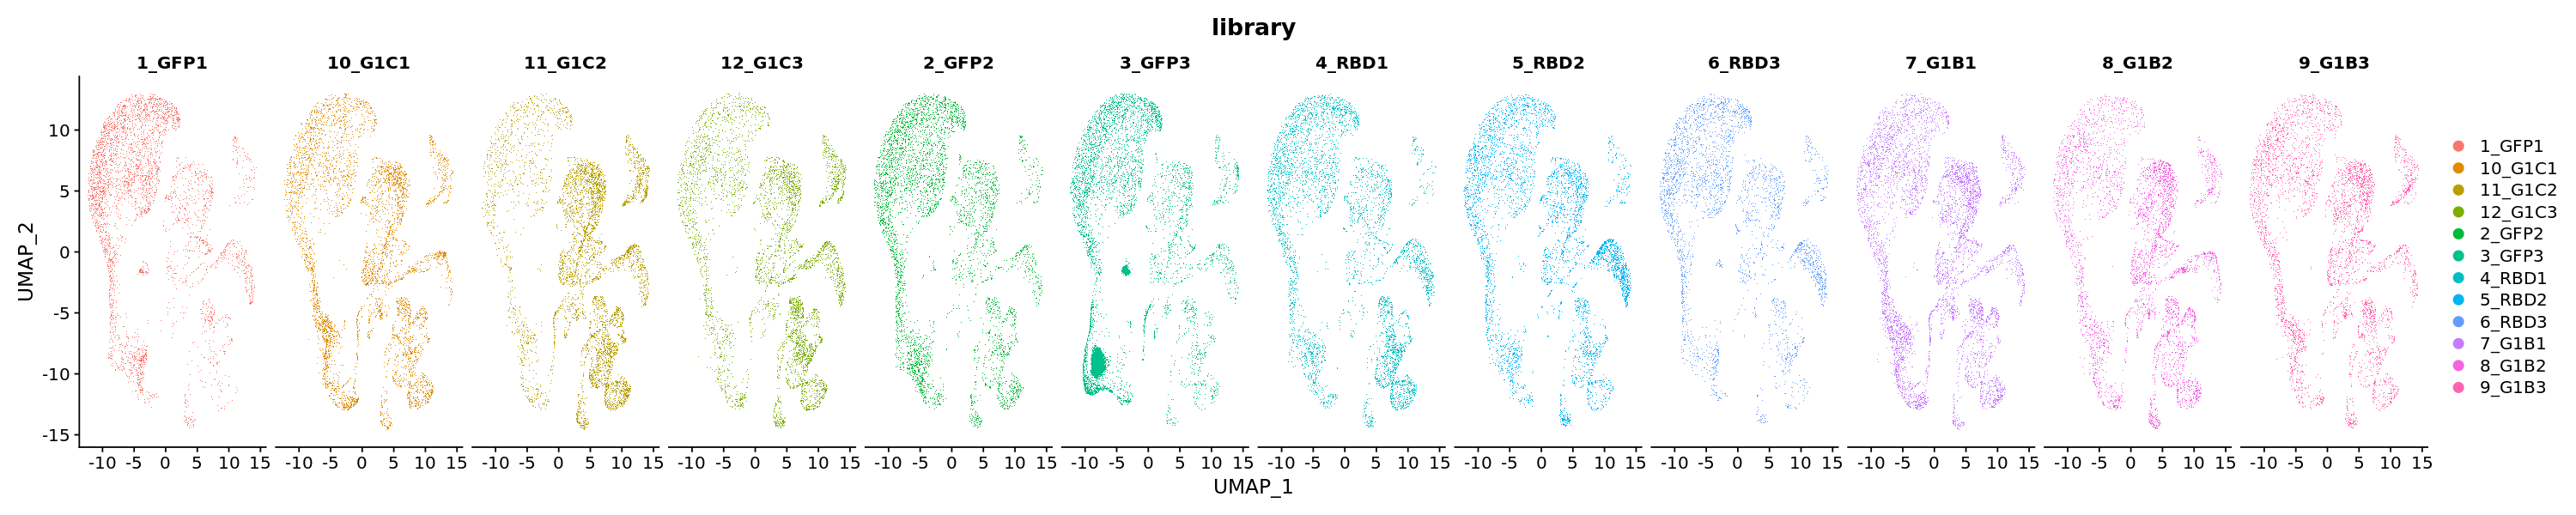

In [20]:
options(repr.plot.width=25, repr.plot.height=5)
p1

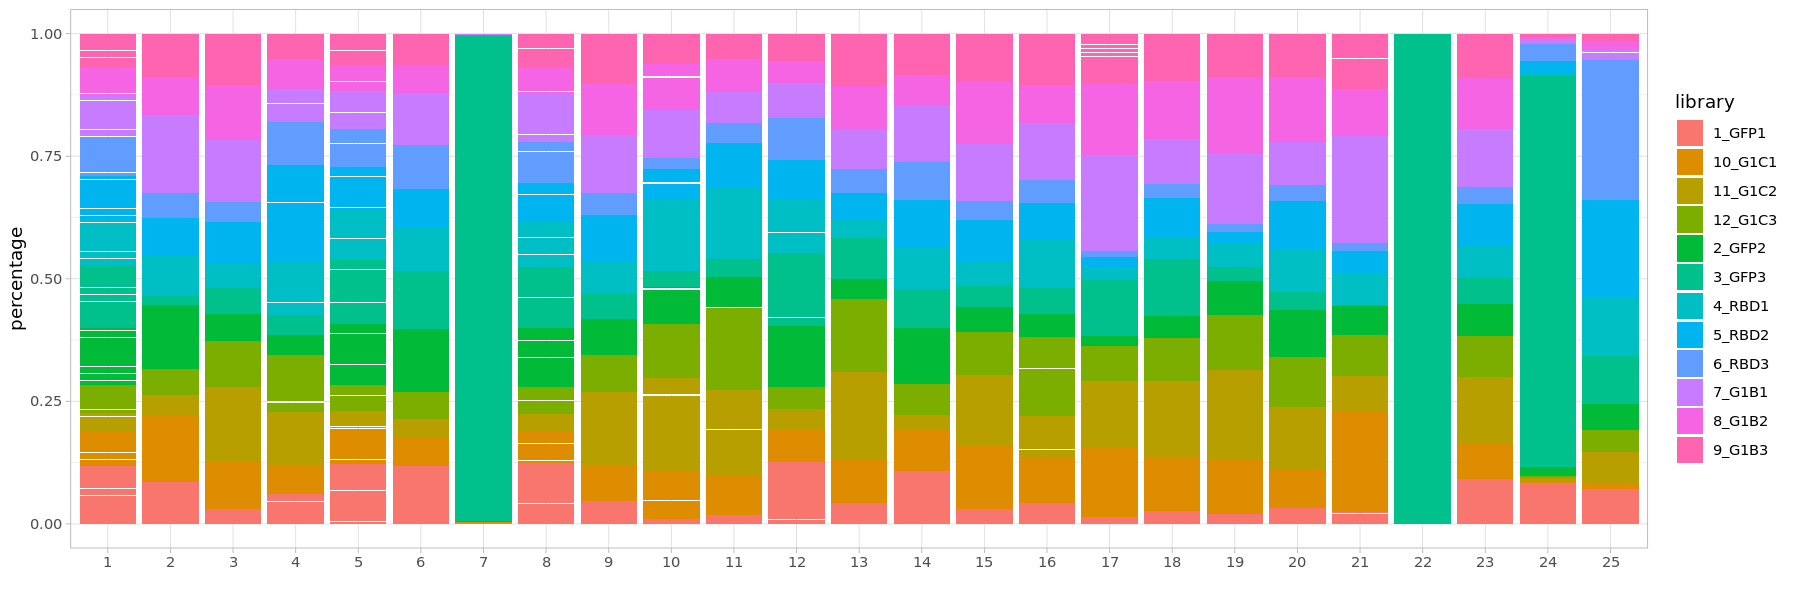

In [21]:
options(repr.plot.width=15, repr.plot.height=5)
p2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



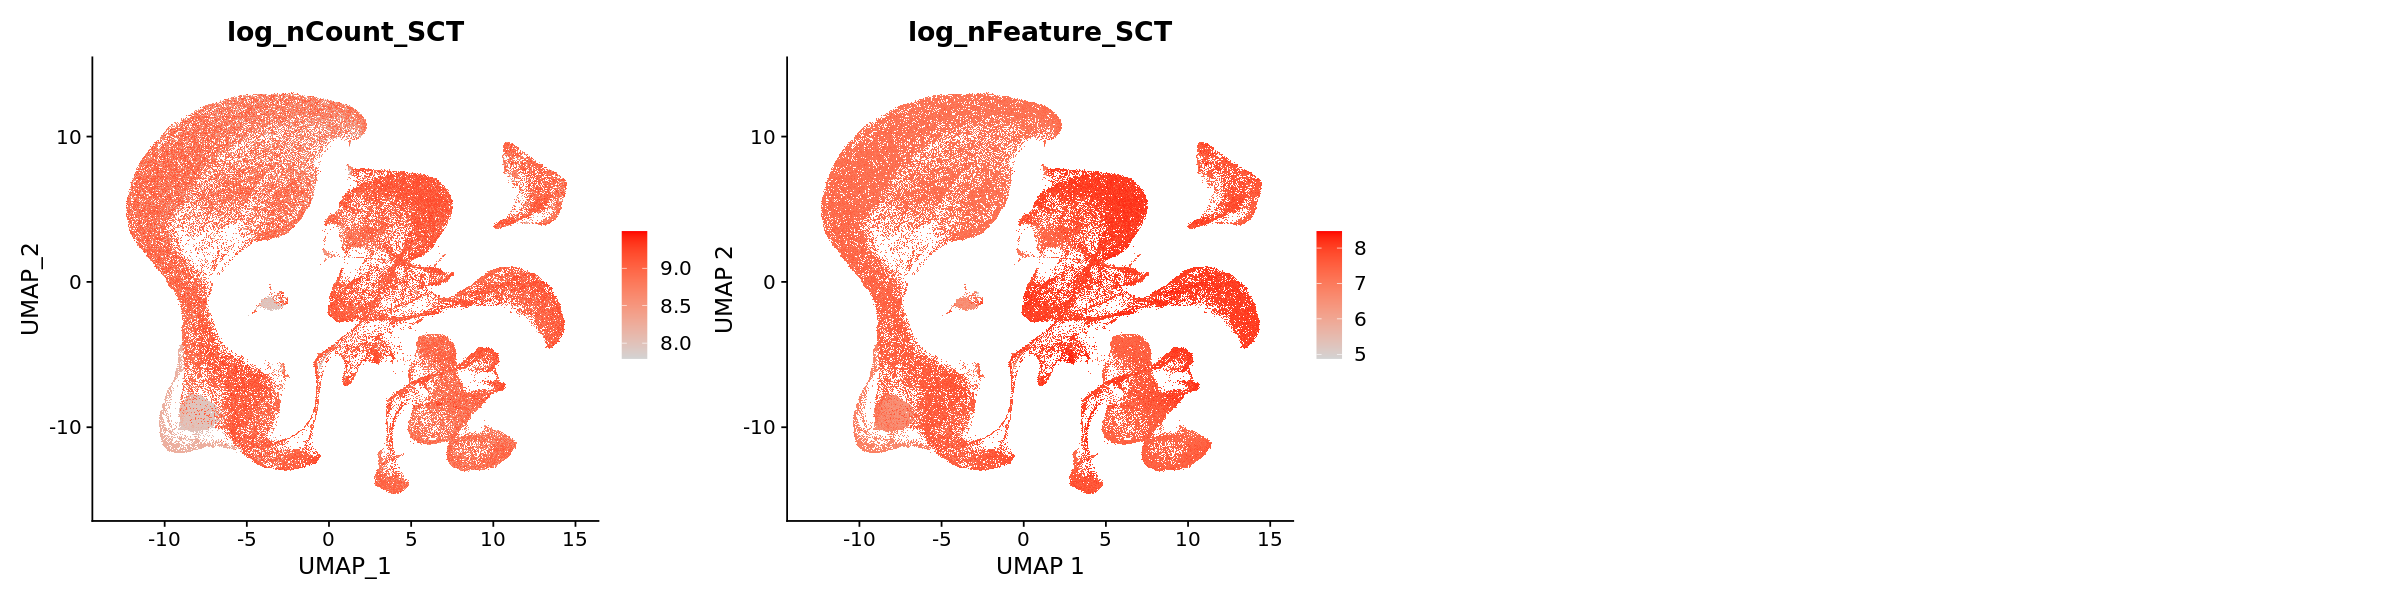

In [22]:
options(repr.plot.width=20, repr.plot.height=5)
p1 <- FeaturePlot(adata, reduction='umap', features=c('log_nCount_SCT','log_nFeature_SCT'), 
                  cols=c('lightgrey', 'red'), ncol=4) + xlab('UMAP 1') + ylab('UMAP 2')
p1 & theme(plot.title=element_text(hjust=0.5))

In [23]:
    ### Overwrite  RDS
    file = paste(step4.dir, "snRNAseq_mrg.rds", sep = "")
    saveRDS(adata, file = file)